### Disciplina de Análise de Séries Temporais Não Lineares - UNIFESP
___

# Análise do preço do ouro em diferentes moedas

##### Autores: Aron Ifanger Maciel, Rodney Rick
___

### Resumo



In [15]:
%matplotlib inline

import pandas as pd
import warnings

import numpy as np
from matplotlib import gridspec
import math
from numpy.matlib import repmat, repeat
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d 

from matplotlib import animation
from matplotlib import cm
from IPython.display import HTML

warnings.filterwarnings('ignore')

In [2]:
gold_usd = pd.read_csv("golden_usd.csv")[280:]
bitcoin_usd = pd.read_csv("bitcoin_usd.csv")

serie_gold = gold_usd.price.values
serie_bitc = bitcoin_usd["price(USD)"]
serie_bitc = serie_bitc[serie_bitc.notnull()].values

In [3]:
import lyapunov_support as lyap
import nltsa_functions as nlts

In [4]:
taug = lyap.find_lag(serie_gold)
mg = lyap.get_dim(serie_gold, taug)

taub = lyap.find_lag(serie_bitc)
mb = lyap.get_dim(serie_bitc, taub)

print("Gold serie: m=", mg, ", tau=", taug)
print("Bitcoin serie: m=", mb, ", tau=", taub)

Gold serie: m= 6 , tau= 16
Bitcoin serie: m= 1 , tau= 30


In [5]:
emb_serie_gold = nlts.psr(serie_gold, m=mg, tau=taug)
emb_serie_bitc = nlts.psr(serie_bitc, m=mb, tau=taub)

## Gráfico de recorrência

In [6]:
#%%writefile -a "nltsa_functions.py"

def distMatrix(points):
    numPoints = len(points)
    distMat = np.sqrt(np.sum((repmat(points, numPoints, 1) - repeat(points, numPoints, axis=0))**2, axis=1))
    return distMat.reshape((numPoints,numPoints))

def rec_data(serie, eps=None, steps=None):
    """
    Função para plotar gráficos de recorrência
    """
    if eps==None: eps=0.01
    if steps==None: steps=10
    Z = np.floor(distMatrix(serie)/eps)
    Z[Z>steps] = steps
    return Z[::-1,:]

def rec_plot(serie):
    plt.figure(figsize=(7,1.5))
    ax = plt.plot(serie[0])
    plt.yticks([])
    plt.show()
    plt.figure(figsize=(7,10))
    plt.imshow(rec_data(serie.T, eps=70, steps=3), cmap='gray')
    plt.yticks([])
    plt.show()

def plot_graph(s, f=rec_plot, eps=None, steps=None):
    fig = plt.figure(figsize=(8, 8)) 
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 4]) 
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    ax1.plot(s)
    ax2.imshow(f(s, eps=eps, steps=steps), cmap='gray')
    plt.show()
    
def plot_rec(ax, s, f=rec_plot, eps=None, steps=None):
    ax.imshow(f(s, eps=eps, steps=steps), cmap='gray')

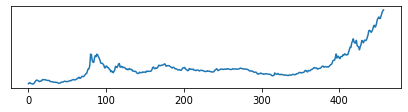

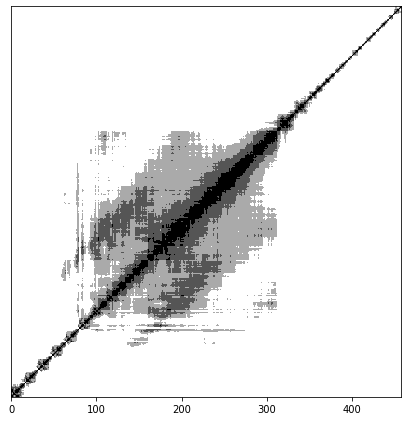

In [7]:
rec_plot(emb_serie_gold)

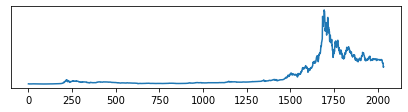

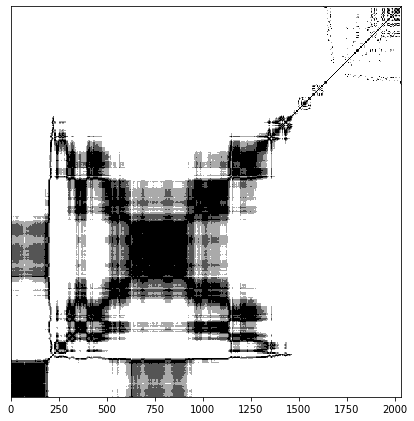

In [8]:
rec_plot(emb_serie_bitc)

In [ ]:
# Animação do resultado do atrator

In [21]:
def animation_atractor(xyz, gif_name="./img/atractor.gif"):
    fig = plt.figure(figsize=(8, 8))
    ax = axes3d.Axes3D(fig)
    def init():
        # Plot the surface.
        ax.plot3D(xyz[0], xyz[1], xyz[2], alpha=0.7, lw=0.3)
        return fig,

    def animate(i):
        # azimuth angle : 0 deg to 360 deg
        ax.view_init(elev=10, azim=i*2)
        return fig,

    # Animate
    ani = animation.FuncAnimation(fig, animate, init_func=init, frames=90, interval=50, blit=True)
    ani.save(gif_name, writer='imagemagick')
    plt.close(fig)

In [24]:
gif_name="./img/atractor.gif"
animation_atractor(emb_serie_gold[0:3], gif_name=gif_name)
HTML('<img src="{}">'.format(gif_name))

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


O primeiro passo consiste na reconstrução do atrator. De acordo com o teorema de Takens, a informação completa sobre os estados ocultos de um sistema dinâmico pode ser presenrvada na série temporal. O espaço de fase é reconstruído a partir de versões 'atrasadas' (time-delayed versions) da série temporal como coordenadas do espaço. Ou seja, dada a série $x_n$, cada elemento $x_i$ da série é mapeado para o ponto $(x_{i−(m−1)\tau} , \dots , x_{i−\tau}, x_i)$ do espaço de dimensão $m$.

Para realizar a reconstrução do atrator é necessário conhecer previamente os parâmetros $m$ (dimensão do sistema) e $\tau$ (time-lag), o que não é óbvio. Existem métodos para estimar estes números, como o 'first minimum of the automutual information function', usado para estimação do time-lag e o 'Cao method' para a dimensão do sistema.

In [ ]:
import pandas as pd
emb_df = pd.DataFrame(emb_serie_gold.T, columns=["d1","d2","d3","d4","d5","d6"])
emb_df.rolling(50).agg(lambda x: x.values)
#emb_df["date"] = gold_usd.reset_index().date

In [ ]:
serie = pd.read_csv("bvsp.csv")
serie.set_index('Date')['Open'].plot(figsize=(18,5))
serie['zero'] = 0
serie['0.3'] = 0.3
serie['lyapunov50'] = serie.Open.rolling(50).agg(lyapunov_)
serie.set_index('Date')[['lyapunov50', 'zero', '0.3']].plot(figsize=(18,3))

In [ ]:
serie = pd.DataFrame({'value':np.random.normal(0,1,1000).cumsum()})
serie['value'].plot(figsize=(18,5))
serie['lyapunov50'] = serie.value.rolling(50).agg(lyapunov_)
serie['zero'] = 0
serie['0.3'] = 0.3
serie[['lyapunov50', 'zero', '0.3']].plot(figsize=(18,5))

In [ ]:
import nolds

In [ ]:
nolds.lyap_e(gold_usd.price, emb_dim=3, matrix_dim=3)

In [ ]:
def generate(data_length, odes, state, parameters):
    data = np.zeros([state.shape[0], data_length])

    for i in range(5000):
        state = rk4(odes, state, parameters)

    for i in range(data_length):
        state = rk4(odes, state, parameters)
        data[:, i] = state

    return data


def rk4(odes, state, parameters, dt=0.01):
    k1 = dt * odes(state, parameters)
    k2 = dt * odes(state + 0.5 * k1, parameters)
    k3 = dt * odes(state + 0.5 * k2, parameters)
    k4 = dt * odes(state + k3, parameters)
    return state + (k1 + 2 * k2 + 2 * k3 + k4) / 6


def lorenz_odes(state, parameters):
    x,y,z=state
    sigma, beta, rho=parameters
    return np.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z])


def lorenz_generate(data_length):
    return generate(data_length, lorenz_odes, \
        np.array([-8.0, 8.0, 27.0]), np.array([10.0, 8/3.0, 28.0]))

In [ ]:
nolds.lyap_e(lorenz_generate(1000)[2], emb_dim=3, matrix_dim=3, tau=3)

In [ ]:
bovespa = pd.read_csv("bvsp.csv").set_index("Date")
bovespa = bovespa[bovespa.Open.notnull()]

In [ ]:
import lyapunov_support_old

In [ ]:
tau = lyap.find_lag(bovespa.Open.values)
m = lyapunov_support_old.calc_attractor_dimension(bovespa.Open.values, tau)

print(tau, m)

In [ ]:
bovespa["lyapunov50"] = bovespa.Open.rolling(50).agg(lambda x: nolds.lyap_r(x, emb_dim=1, tau=1))

In [ ]:
bovespa.Open.plot(figsize=(18,5))
bovespa['zero'] = 0
bovespa['0.2'] = 0.2
bovespa[['lyapunov50', 'zero', '0.2']].plot(figsize=(18,5))

In [ ]:
import numpy as np
np.array([1,2,3])[:-1]

In [ ]:
#old = np.random.rand(100)
new = np.roll(old, -1)

comp = abs(old - new) <= abs(new / 100)
np.arange(100)[comp]

In [ ]:
import nolds

nolds.lyap_r?